In [1]:
from Bio import SeqIO
import numpy as np
from numba import njit
from numba import int32, float32    # import the types
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm



## Pre-process methods


In [2]:
def get_recs(file_name):
    with open(file_name) as handle:
        seqs = []
        #ids = []
        for record in SeqIO.parse(handle, "fasta"):
            seqs.append(record.seq)
            #ids.append(record.id)
        # for ints .view(np.uint32)
        return np.array(seqs).view(np.uint32)#, np.array(ids))
    
@njit
def get_mutations(reference, seqs):
    diff = np.zeros(seqs.shape, dtype=np.int8)
    
    
    for i in range(seqs.shape[0]):
        for j in range(seqs.shape[1]):
            if reference[j] != seqs[i][j] & seqs[i][j] != 110: # number for n, ord('n')
                diff[i][j]= 1
    
    return diff

@njit
def get_mapped_mutations(reference, seqs):
    #diff = np.zeros(seqs.shape, dtype=np.int32)
    
    indexes = np.zeros((seqs.shape[1]), dtype=np.int32)
    
    
    mapping ={97:1, # number for a, ord('a')
              116:-1, # number for t, ord('t')
              99:2, # number for c, ord('c')
              103:-2, # number for g, ord('g')
              45:3 # number for -, ord('-')
             }
    
    for i in range(seqs.shape[0]):
        
        for j in range(seqs.shape[1]):
            value = seqs[i][j]
            seqs[i][j] = 0
            if reference[j] != value:
                val = mapping.get(value, 0) # everything not a key that differs from ref is 0
                seqs[i][j]= val
                if val!=0:
                    indexes[j]+=1
                    
    indexes = indexes>0.003*seqs.shape[0]
    
    return seqs[:,indexes].astype(np.int32)



       

## READ GENOMES

In [4]:
path1 = "/home/da150x_47/KEX/SWDN0.fa"
# get all records (sequences, id´s)
seqs = get_recs(path1)
print(seqs.shape)

(50000, 31182)


In [5]:
path1 = "/home/da150x_47/KEX/SWDN50000.fa"
# get all records (sequences, id´s)
seqs2 = get_recs(path1)
print(seqs2.shape)

(50000, 31182)


In [4]:
path1 = "/home/da150x_47/KEX/SWDN100000.fa"
# get all records (sequences, id´s)
seqs3 = get_recs(path1)
print(seqs3.shape)

(16299, 31182)


In [5]:
seqs = np.load("Sweden/saveseqs1.npy")

In [6]:
seqs_N = np.vstack([seqs, seqs3])
print(seqs_N.shape)

(116299, 31182)


In [3]:
saveseqs = np.vstack([seqs, seqs2])
print(saveseqs.shape)
np.save("Sweden/saveseqs1", saveseqs)

NameError: name 'seqs' is not defined

In [ ]:
%%time

path1 = "/home/da150x_47/KEX/Sweden/Sweden.fasta"
# get all records (sequences, id´s)
seqs = get_recs(path1)
print(seqs.shape)

In [7]:
reference_genome = seqs_N[0]
#reference_id = ids[0]
seqs = seqs_N[1:]
#ids = ids[1:]
seqs.shape

(116298, 31182)

In [8]:
#%time np.save("Sweden/seqs_sweden", seqs)
#np.save("Sweden/reference_sweden", reference_genome)

CPU times: user 4.19 s, sys: 2.78 s, total: 6.97 s
Wall time: 22.5 s


# LOAD SAVED SEQS

In [3]:
%time seqs = np.load("Sweden/seqs_sweden.npy")
reference_genome = np.load("Sweden/reference_sweden.npy")
seqs.shape

CPU times: user 27.7 ms, sys: 8.11 s, total: 8.14 s
Wall time: 26.2 s


(116298, 31182)

## READ LINEAGES/CLUSTERS

In [16]:
%%time
import pandas as pd

Path = "Sweden/sweden_data.csv"
df = pd.read_csv(Path)


CPU times: user 253 ms, sys: 35.7 ms, total: 288 ms
Wall time: 374 ms


## Pre-process 

In [4]:
%%time
seqs = get_mapped_mutations(reference_genome, seqs)
print(seqs.shape)

(116298, 3653)
CPU times: user 8 s, sys: 989 ms, total: 8.99 s
Wall time: 8.46 s


## PCA

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_seqs = scaler.fit_transform(seqs)

In [8]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components=scaled_seqs.shape[1],
          random_state=0)

scaled_seqs = pca.fit_transform(scaled_seqs)

CPU times: user 23min 5s, sys: 53.9 s, total: 23min 59s
Wall time: 3min 8s


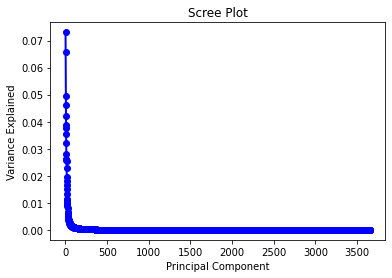

In [9]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [10]:
num_components = 0
variance_percentage = 0
for p in pca.explained_variance_ratio_:
    variance_percentage+=p
    num_components+=1
    if variance_percentage>0.90:
        break
print(num_components,variance_percentage)

157 0.9002944791595803


In [11]:
reduced_data = scaled_seqs[:,:num_components+1]
np.save("Sweden/reduced_data2", reduced_data)

# load saved reduced data

In [7]:
reduced_data = np.load("Sweden/reduced_data2.npy")

# CLUSTERING
comparison:
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

### ELBOW METHOD


In [12]:
%%time
from yellowbrick.cluster import KElbowVisualizer

CPU times: user 150 ms, sys: 8.1 ms, total: 159 ms
Wall time: 157 ms


In [71]:
# Generate synthetic dataset with 8 random clusters

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(init="k-means++",  
                        random_state=0,
                        max_iter=100,
                        max_no_improvement=2*reduced_data.shape[0]/1024, #2 epochs
                       )

visualizer = KElbowVisualizer(model, k=(6,20), metric= 'silhouette')

visualizer.fit(reduced_data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure"""


N_CLUSTERS = visualizer.elbow_value_

SyntaxError: EOF while scanning triple-quoted string literal (3180313872.py, line 16)

## K-MEANS

In [ ]:
%%time
from sklearn.cluster import MiniBatchKMeans 
#2.8 sec for seqs

kmeans1 = MiniBatchKMeans(init="k-means++", 
                         n_clusters= 12, 
                         random_state=0,
                         max_iter=100,
                         #verbose = 1,
                         n_init = 10,
                         max_no_improvement=None #2*reduced_data.shape[0]/1024, #2 epochs
                        )
kmeans1.fit(reduced_data)


km_clusters1 = kmeans1.predict(reduced_data)

print(kmeans1.n_iter_)
df["km_clusters1"] = km_clusters1

In [17]:
%%time
from sklearn.cluster import MiniBatchKMeans 
#2.8 sec for seqs

kmeans2 = MiniBatchKMeans(init="k-means++", 
                         n_clusters= 12, 
                         random_state=0,
                         max_iter=200,
                         #verbose = 1,
                         n_init = 5,
                         max_no_improvement=None #2*reduced_data.shape[0]/1024, #2 epochs
                        )
kmeans2.fit(reduced_data)


km_clusters2 = kmeans2.predict(reduced_data)

print(kmeans2.n_iter_)
df["km_clusters2"] = km_clusters2

200
CPU times: user 1min 45s, sys: 3.37 s, total: 1min 48s
Wall time: 15.4 s


## AgglomerativeClustering good

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

alt testa denna också
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html#sklearn.cluster.FeatureAgglomeration

In [18]:
%%time
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(reduced_data, 100, include_self=True)
#connectivity gets same result, only faster

CPU times: user 6min 33s, sys: 6min 35s, total: 13min 9s
Wall time: 3min 43s


In [19]:
%%time
#45 sec for seqs
from sklearn.cluster import AgglomerativeClustering

agg_model = AgglomerativeClustering(n_clusters=12,
                                       connectivity= connectivity
                                   )
agg_clusters = agg_model.fit_predict(reduced_data)

df["agg_clusters"] = agg_clusters

CPU times: user 1min 51s, sys: 1.24 s, total: 1min 52s
Wall time: 1min 52s


## SAVE CLUSTERS

In [20]:
#write to a csv with clusters
df.to_csv("Sweden/sweden_data_clusters2.csv",index=False )

Path = "Sweden/sweden_data_clusters2.csv"
df = pd.read_csv(Path)

## 4.3 SOM

In [21]:
import random
from pyclustering.utils import read_sample
from pyclustering.nnet.som import som, type_conn, type_init, som_parameters


In [22]:
%%time
# create SOM parameters
parameters = som_parameters()
#parameters.learning_rate = 0.002

# create self-organized feature map with size 15x15
rows = 15  # 15 rows
cols = 15  # 15 columns

structure = type_conn.grid_four;  # each neuron has max. four neighbors.
network = som(rows, cols, structure, parameters)


# train network on 'Lsun' sample during 200 epouchs.
iterations = network.train(data = reduced_data,
              epochs = 200,
              autostop = True
             )
print(f"SOM ran for {iterations} iterations")

SOM ran for 201 iterations
CPU times: user 10min 11s, sys: 464 ms, total: 10min 11s
Wall time: 10min 12s


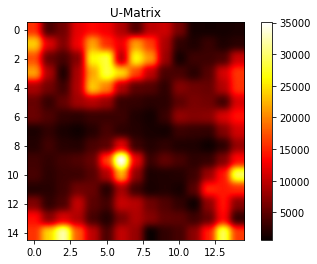

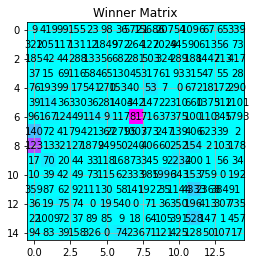

In [23]:
# result visualization:
# show distance matrix (U-matrix).
network.show_distance_matrix()
# show density matrix (P-matrix).
#network.show_density_matrix()
# show winner matrix.
network.show_winner_matrix()
# show self-organized map.
#network.show_network()

## 4.3 Post-process


In [24]:

# number of non-dead clusters
winners = network.get_winner_number()
display(winners)

#indexes sorted by each node
clusters = network.capture_objects

#np.save("Sweden/winners_sweden2", np.array(winners, dtype=object))
#np.save("Sweden/clusters_sweden2", np.array(clusters, dtype=object))

219

In [11]:
winners = np.load("Sweden/winners_sweden2.npy", allow_pickle = True)
clusters = np.load("Sweden/clusters_sweden2.npy", allow_pickle = True)

rows = 15  # 15 rows
cols = 15  # 15 columns

import pandas as pd

Path = "Sweden/sweden_data_clusters2.csv"
df = pd.read_csv(Path)

In [50]:
from matplotlib.colors import LinearSegmentedColormap

#9
alpha = ['#7b80ef', '#4e56ee', '#3b44ed',
         '#a986f1', '#824fea', '#d3bdfe', '#7c7eaa', '#4ea5ff', '#76caff']

#7
beta = ['#f7a16f','#bd2800', '#d95757','#f33300', '#c33a32',
        '#ee5830', '#eb5e00', '#a05750', '#cf6447', '#ffac75', '#e86052']
KMcolor_dict = {0: beta[0], #b
                1: beta[1], #b
                2: alpha[0], #a
                3: beta[2], #b
                4: beta[3], #b
                5: beta[4], #b
                6: alpha[1], #a
                7: alpha[2], #a
                8: beta[5], #b
                9: beta[6], #b
                10: beta[7], #b
                11: alpha[3], #a
                12:'#eae84f' #dead
                }

AGGcolor_dict = {0: beta[0], #b
                1: beta[1], #b
                2: beta[2], #b
                3: beta[3], #b
                4: alpha[0], #a
                5: alpha[1], #a
                6: alpha[2], #a
                7: alpha[3], #a
                8: beta[4], #b
                9: alpha[4], #a
                10: beta[5], #b
                11: beta[6], #b
                12:'#eae84f' #dead
                }

In [51]:

def hitmap_by(BY, color_dict = None, axis_data = 0, title = ''):
    clusters_lineage = []
    
    
    
    for i in clusters:

        lineages = df.iloc[i][BY].to_list()
        clusters_lineage.append(lineages)
        
    cluster_maxes = []
    percentage_maxes = []

    for l_c in clusters_lineage:
        data_samples = len(l_c) 

        if data_samples>0:      
            clusters_u, distr_u = np.unique(l_c, return_counts=True)
            indexes = np.argsort(distr_u)
            max_l = (list(zip(clusters_u[indexes], distr_u[indexes]))[-1])
            cluster_maxes.append(max_l[0])
            percentage_maxes.append(max_l[1]/data_samples)
        else:
            #cluster_maxes.append("dead")
            cluster_maxes.append(12) #dead
            percentage_maxes.append(0)

    cluster_maxes = np.array(cluster_maxes).reshape(rows,cols, order='F')
    percentage_maxes = np.array(percentage_maxes).reshape(rows,cols, order='F')

    (fig, ax) = plt.subplots()
    ##################
    # axis_data =1, percentage
    if axis_data ==1:
        for i in range(rows):
            for j in range(cols):
                ax.text(i, j, str(round(percentage_maxes[j][i] * 10)), va='center', ha='center')
    # axis_data =2, cluster
    if axis_data ==2:
        for i in range(rows):
            for j in range(cols):
                a_d = cluster_maxes[j][i]
                if a_d==12:#'dead':
                    a_d = 'd'
                ax.text(i, j, str(a_d), va='center', ha='center')
    ###################
    
    if color_dict == None:
        cmap = 'viridis'
    else:
        cmap = LinearSegmentedColormap.from_list(color_dict.keys(),
                                                 list(color_dict.values()))
    
    im = plt.imshow(cluster_maxes,
                   cmap= cmap,#'viridis',
                   #interpolation = 'bilinear',
                  )
    
    patches = [mpatches.Patch(color=color_dict.get(i),
                              label=f"Cluster {i}" if i!=12 else 'Dead') for i in range(13)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    
    plt.title(title)
    plt.show()



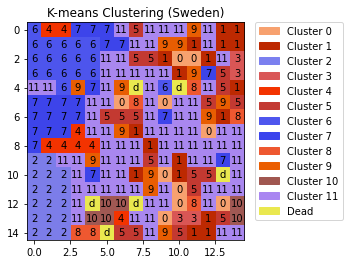

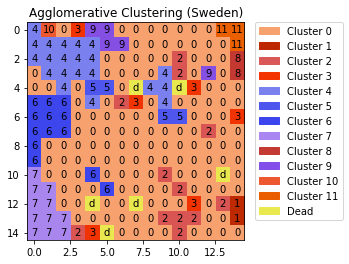

In [53]:
hitmap_by("km_clusters2",axis_data = 2, title = 'K-means Clustering (Sweden)', color_dict = KMcolor_dict) 
hitmap_by("agg_clusters",axis_data = 2, title = 'Agglomerative Clustering (Sweden)', color_dict = AGGcolor_dict)
#hitmap_by("pangolin_lineage",1 )

In [54]:
a, b = np.unique(df['agg_clusters'], return_counts = True)
display(a, b)
b[0]/np.sum(b)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

array([92418,  1193,  7527,  3266,  3411,  1217,  1061,  1855,   493,
        2974,   431,   452])

0.7946654284682454

In [55]:
np.unique(df['km_clusters2'], return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 7100,  9483,  2117,  1373,  3615, 21035,  3300,  5099,  3239,
        25975,  1933, 32029]))

# HAMMING DISTANCE


In [5]:
@njit
def hamming_distance(X, Y, ignore_diag = True):
    n = 0 # number of samles
    m = X.shape[1] # dimension of samples
    
    X1 = 0
    X2 = 0


    for i, x in enumerate(X):
        for j, y in enumerate(Y): 
            
            if i==j and ignore_diag:
                continue
            hamming_distance = (m-np.sum(x==y))/m  # normalized hamming distance(%)
            n +=1
            X1 += hamming_distance
            X2 += hamming_distance**2

    mean = X1/n
    std = np.sqrt((X2-mean**2)/(n-1)) #sample distribution
    
    return mean, std

## cluster/lineage comparison

In [8]:
def compare_clusters_lineages_inter(clusters, lineage):
    
    means = []
    stds = []
    labels = []
    
    for cluster1 in tqdm(clusters):
        for cluster2 in clusters:
            
            if cluster1 == cluster2:
                break
            
            index1 = df.loc[(df['km_clusters2']==cluster1).values & (df['pangolin_lineage']==lineage).values].index
            index2 = df.loc[(df['km_clusters2']==cluster2).values & (df['pangolin_lineage']==lineage).values].index
            
            c1 = seqs[index1]
            c2 = seqs[index2]
            
            mean, std = hamming_distance(c1,c2, ignore_diag = False)
            means.append(mean)
            stds.append(std)
            labels.append(f'{cluster1}, {cluster2}')
    
    plt.figure()
    for index, l in enumerate(labels):
        plt.errorbar(index ,means[index], stds[index], linestyle='None', marker='^')
    
    plt.title(f'Intercluster Hamming Distance for Lineage {lineage} in Clusters {str(clusters)[1:-1]} (Sweden)')
    plt.grid(True)
    plt.xticks(range(len(labels)), labels)
    plt.xticks(rotation = 90)
    plt.ylim([-0.02, 0.35])
    plt.xlabel('Clusters')
    plt.ylabel('Hamming Distance (%)')
    plt.show

In [9]:
#1,2,3,6,7,10 AY.43
def compare_clusters_lineages_intra(clusters, lineage):
    
    means = []
    stds = []
    
    for cluster in tqdm(clusters):
        index = df.loc[(df['km_clusters2']==cluster).values & (df['pangolin_lineage']==lineage).values].index
        c = seqs[index]
        print(len(index))
        mean, std = hamming_distance(c,c, ignore_diag = True)
        means.append(mean)
        stds.append(std)
    
    plt.figure()
    for index, c in enumerate(clusters):
        plt.errorbar(index ,means[index], stds[index], linestyle='None', marker='^')
    
    plt.title(f'Intracluster Hamming Distance for Lineage {lineage} in Clusters {str(clusters)[1:-1]} (Sweden)')
    plt.grid(True)
    plt.ylim([-0.02, 0.35])
    plt.xticks(range(len(clusters)), clusters)
    plt.xlabel('Clusters')
    plt.ylabel('Hamming Distance (%)')
    plt.show

  0%|          | 0/7 [00:00<?, ?it/s]

2996
536
2756
19938
2877
25335
1139


  0%|          | 0/7 [00:00<?, ?it/s]

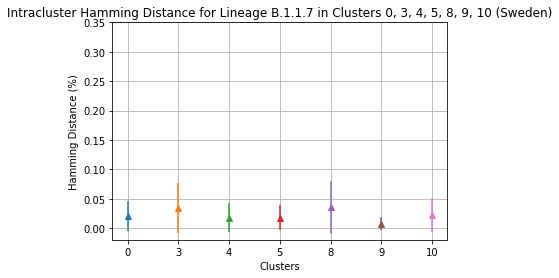

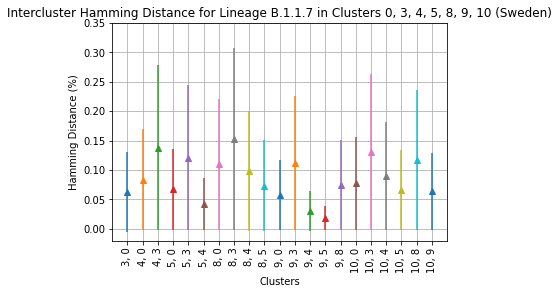

In [12]:
# 0, 3, 6, 8, 9, 10  'B.1.1.7'
compare_clusters_lineages_intra(clusters = [0,3,4, 5, 8 ,9 ,10], lineage = 'B.1.1.7') # 1 min
compare_clusters_lineages_inter(clusters = [0,3,4, 5, 8, 9, 10], lineage = 'B.1.1.7') # 1.30 min

  0%|          | 0/5 [00:00<?, ?it/s]

286
520
708
216
5362


  0%|          | 0/5 [00:00<?, ?it/s]

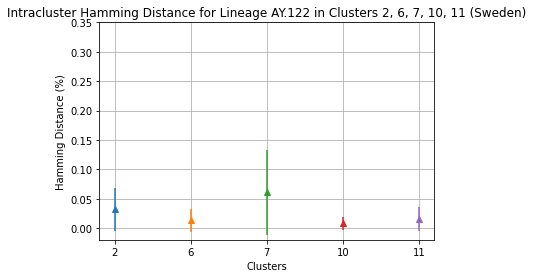

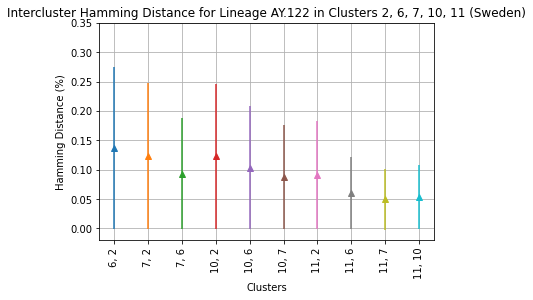

In [13]:
# 2,7,9  'AY.43'
compare_clusters_lineages_intra(clusters = [2,6,7,10,11], lineage = 'AY.122') # 1 min
compare_clusters_lineages_inter(clusters = [2,6,7,10,11], lineage = 'AY.122') # 1.30 min

In [17]:
#7 och 8 'B.1.1.7' 'AY.122'


index1 = df.loc[(df['km_clusters2']==8).values & (df['pangolin_lineage']=='AY.122').values].index
index2 = df.loc[(df['km_clusters2']==8).values & (df['pangolin_lineage']=='B.1.1.7' ).values].index

print(len(index1))
print(len(index2))

c1 = seqs[index1]
c2 = seqs[index2]

mean, std = hamming_distance(c1,c2, ignore_diag = False)

print(mean, std)

264
618
0.030235512873804098 0.03599237687347985


## INTRA-CLUSTER HAMMING DISTANCE

In [60]:
from scipy import stats


"""
def null_hypothesis(data):
    k2, p = stats.normaltest(data)
    alpha = 1e-3
    #print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print("The null hypothesis can be rejected")
        pass
    else:
        print("The null hypothesis cannot be rejected")
        
        """
def hamming_intra(clusters, csv_name = 'Hamming_inter', all_lineages = False):
    if clusters=='pangolin_lineage':
        if all_lineages == False:
            no_clusters = ['B.1', 'B.1.1','B.1.1.261', 'B.1.1.302', 'B.1.258', 'B.1.177', 'B.1.160',  'B',
                       'B.4', 'B.1.1.7', 'B.1.258.22','AY.75', 'AY.122', 'AY.4', 'AY.9.2', 'AY.43']
        else:
            no_clusters, cluster_count = np.unique(df['pangolin_lineage'], return_counts=True)
            no_clusters = no_clusters[cluster_count>20]
    else: 
        no_clusters, cluster_count = np.unique(df[clusters], return_counts=True)
    
    csv_cols = []
    csv_data = []
    
    for l in tqdm(no_clusters):
        indexes = df.loc[df[clusters]==l].index
        c = seqs[indexes]
        
        mean, std = hamming_distance(c,c, ignore_diag = True)
        #null_hypothesis(dm)
        csv_data.append([mean, std])
        csv_cols.append(f"{l}")
        
    hamming_csv = pd.DataFrame(data = np.transpose(csv_data),
                               columns = csv_cols,
                               index = ['inter-mean', 'inter-std'])
    hamming_csv.to_csv(f"Sweden/{csv_name}")

    
    
    
def plot_intra_hamming(csv_path, title = 'yes', rotate_labels = False):
    hamming_csv = pd.read_csv(csv_path, index_col=0)
    
    cols = hamming_csv.columns 
    for index, c in enumerate(cols):
        mean, std = hamming_csv[c]
        plt.errorbar(index, mean, std, linestyle='None', marker='^')
        
    plt.grid(True)
    plt.xlabel('Clusters')
    plt.ylabel('Hamming Distance (%)')
    plt.xlim([-1,len(cols)])
    plt.title(title)
    plt.ylim([-0.02, 0.2])
    plt.xticks(range(len(cols)), cols)
    if rotate_labels:
        plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.show()                        
               

## INTER-CLUSTER HAMMING DISTANCE

In [58]:

def hamming_inter(clusters, csv_name = 'Hamming_inter', all_lineages = False):
      
    if clusters=='pangolin_lineage':
        if all_lineages == False:
            no_clusters = ['B.1', 'B.1.1','B.1.1.261', 'B.1.1.302', 'B.1.258', 'B.1.177', 'B.1.160',  'B',
                       'B.4', 'B.1.1.7', 'B.1.258.22','AY.75', 'AY.122', 'AY.4', 'AY.9.2', 'AY.43']
        else:
            no_clusters, cluster_count = np.unique(df['pangolin_lineage'], return_counts=True)
            no_clusters = no_clusters[cluster_count>20]
    else: 
        no_clusters, cluster_count = np.unique(df[clusters], return_counts=True)
    
    
    csv_cols = []
    csv_data = []
    
    for i in tqdm(no_clusters):
        for j in (no_clusters):
            if i==j:
                break

            indexes1 = df.loc[df[clusters]==i].index
            indexes2 = df.loc[df[clusters]==j].index
            c1 = seqs[indexes1]
            c2 = seqs[indexes2]

            mean, std = hamming_distance(c1,c2, ignore_diag = False)
            #null_hypothesis(dm)
            csv_data.append([mean, std])
            csv_cols.append(f"{i},{j}")
    
    hamming_csv = pd.DataFrame(data = np.transpose(csv_data),
                               columns = csv_cols,
                               index = ['inter-mean', 'inter-std'])
    hamming_csv.to_csv(f"Sweden/{csv_name}")



def plot_inter_hamming(csv_path, title = 'yes'):
    hamming_csv = pd.read_csv(csv_path, index_col=0)
    plt.figure(figsize=(22,10))
    
    cols = hamming_csv.columns 
    for index, c in enumerate(cols):
        mean, std = hamming_csv[c]
        plt.errorbar(index, mean, std, linestyle='None', marker='^')
        
    plt.grid(True)
    plt.xlabel('Clusters')
    plt.ylabel('Hamming Distance (%)')
    plt.xlim([-1,len(cols)])
    plt.title(title)
    plt.xticks(range(len(cols)), cols)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.show()


# calculate intra hamming

In [30]:

hamming_intra(clusters = 'km_clusters2',
              csv_name = 'INTRA-km200_2',
              all_lineages = False)

hamming_intra(clusters = 'pangolin_lineage',
              csv_name = 'INTRA-pango-top_2',
              all_lineages = False)

hamming_intra(clusters = 'pangolin_lineage',
              csv_name = 'INTRA-pango-all_2',
              all_lineages = True)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

# plot intra hamming

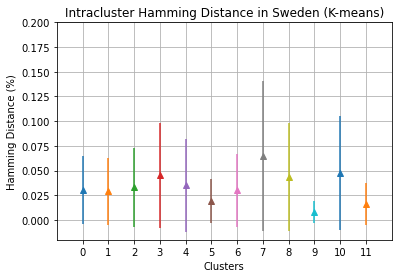

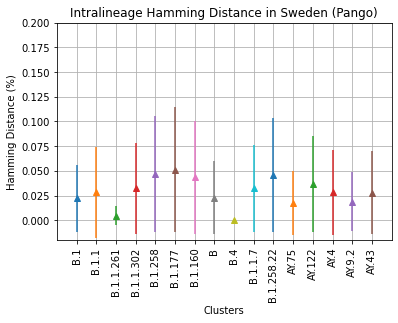

In [61]:

plot_intra_hamming(csv_path = "Sweden/INTRA-km200_2",
                   rotate_labels = False,
                   title = 'Intracluster Hamming Distance in Sweden (K-means)')

plot_intra_hamming(csv_path = "Sweden/INTRA-pango-top_2",
                   rotate_labels = True,
                   title = 'Intralineage Hamming Distance in Sweden (Pango)')


# calculate inter hamming

In [32]:

hamming_inter(clusters = 'km_clusters2',
                   csv_name = 'INTER-km200_2',
                   all_lineages = False)

hamming_inter(clusters = 'pangolin_lineage',
                   csv_name = 'INTER-pango-top_2',
                   all_lineages = False)

hamming_inter(clusters = 'pangolin_lineage',
                   csv_name = 'INTER-pango-all_2',
                   all_lineages = True)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

# plot intra hamming

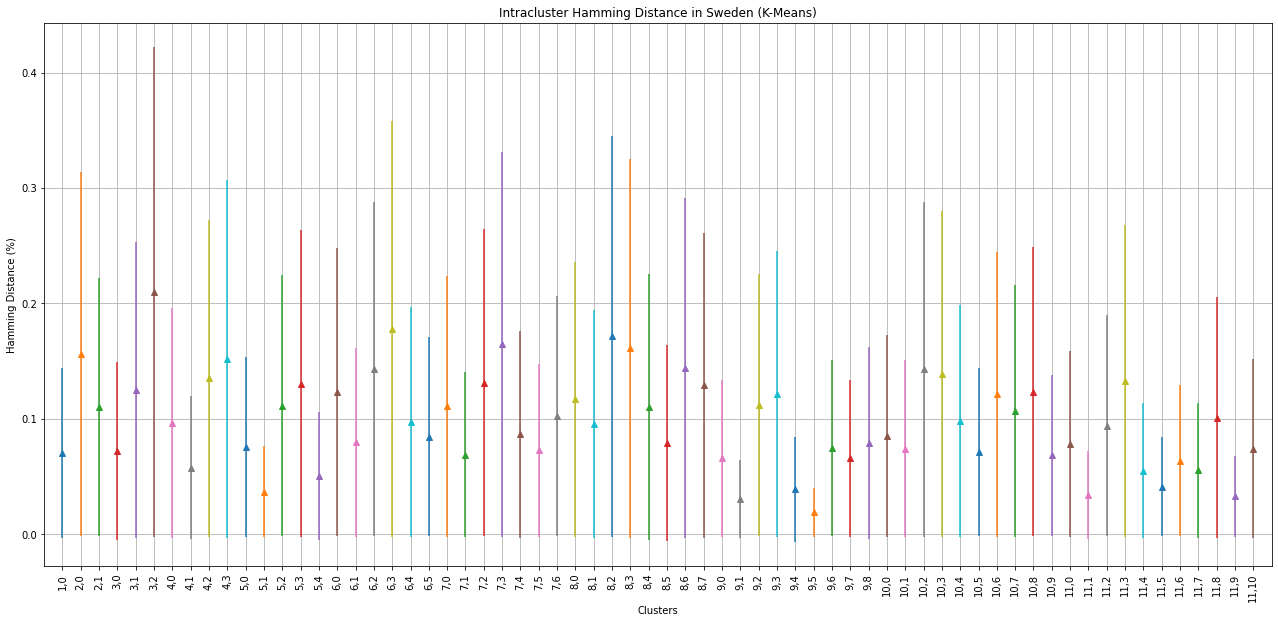

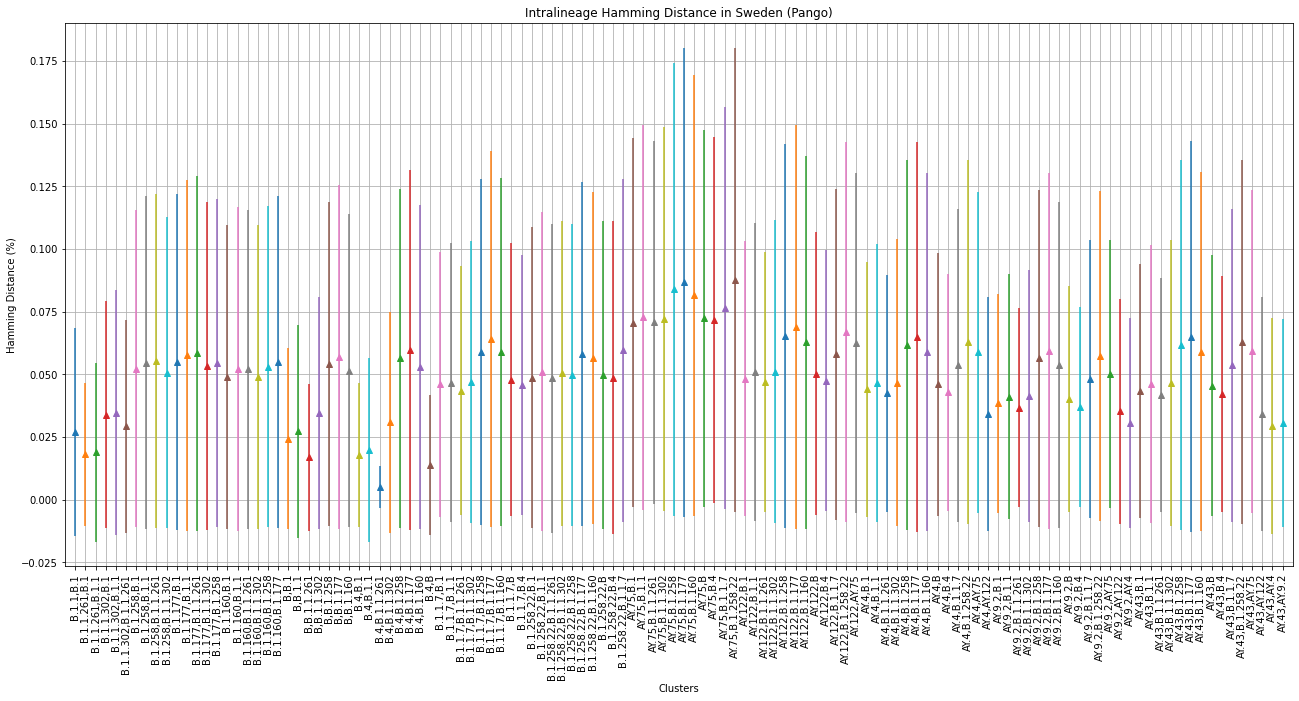

In [62]:
plot_inter_hamming("Sweden/INTER-km200_2", title = 'Intracluster Hamming Distance in Sweden (K-Means)')

plot_inter_hamming("Sweden/INTER-pango-top_2", title = 'Intralineage Hamming Distance in Sweden (Pango)')


# hamming tables

In [34]:

inter_km_mean2 = pd.read_csv("Sweden/INTER-km200_2", index_col=0).iloc[0].mean()
inter_km_std2 = pd.read_csv("Sweden/INTER-km200_2", index_col=0).iloc[1].mean()

inter_pango_mean_top = pd.read_csv("Sweden/INTER-pango-top_2", index_col=0).iloc[0].mean()
inter_pango_std_top = pd.read_csv("Sweden/INTER-pango-top_2", index_col=0).iloc[1].mean()

inter_pango_mean_all = pd.read_csv("Sweden/INTER-pango-all_2", index_col=0).iloc[0].mean()
inter_pango_std_all = pd.read_csv("Sweden/INTER-pango-all_2", index_col=0).iloc[1].mean()

In [35]:
inter_cluster_table = pd.DataFrame(data = [[inter_km_mean2, inter_pango_mean_top, inter_pango_mean_all],
                                           [ inter_km_std2, inter_pango_std_top, inter_pango_std_all]],
                                   index = ['Inter-mean', 'Inter-std'],
                                   columns = [ 'km200', 'pango top', 'pango all']
                                  )
display(inter_cluster_table)

,km200,pango top,pango all
Inter-mean,0.097692,0.049985,0.048348
Inter-std,0.100183,0.059429,0.058710


In [36]:

intra_km_mean2 = pd.read_csv("Sweden/INTRA-km200_2", index_col=0).iloc[0].mean()
intra_km_std2 = pd.read_csv("Sweden/INTRA-km200_2", index_col=0).iloc[1].mean()

intra_pango_mean_top = pd.read_csv("Sweden/INTRA-pango-top_2", index_col=0).iloc[0].mean()
intra_pango_std_top = pd.read_csv("Sweden/INTRA-pango-top_2", index_col=0).iloc[1].mean()

intra_pango_mean_all = pd.read_csv("Sweden/INTRA-pango-all_2", index_col=0).iloc[0].mean()
intra_pango_std_all = pd.read_csv("Sweden/INTRA-pango-all_2", index_col=0).iloc[1].mean()

In [37]:
intra_cluster_table = pd.DataFrame(data = [[ intra_km_mean2, intra_pango_mean_top, intra_pango_mean_all],
                                           [ intra_km_std2, intra_pango_std_top, intra_pango_std_all]],
                                   index = ['Intra-mean', 'Intra-std'],
                                   columns = [ 'km200', 'pango top', 'pango all']
                                  )
display(intra_cluster_table)

,km200,pango top,pango all
Intra-mean,0.033512,0.028751,0.029572
Intra-std,0.040778,0.040598,0.042161
